A notebook where I figured out how to best perform the globular cluster cuts. There's a lot of scratchwork here. Use gc_cuts.py to get perform any cuts

In [1]:
import astropy.table as at
from astropy.io import ascii
from astropy.table import Table
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# makes plots look nicer
plt.rcParams['figure.dpi'] = 300

In [2]:
# Function to parse declination strings and convert to decimal degrees
def parse_declination(dec_str):
    sign = -1 if dec_str.startswith('-') else 1
    dec_str = dec_str.strip('+-')  # Remove leading '+' or '-' for splitting
    parts = dec_str.split()
    degrees = int(parts[0])
    minutes = int(parts[1])
    seconds = float(parts[2])
    return sign * (degrees + minutes / 60 + seconds / 3600)

In [3]:
# first, split the file into three sections:

# Read the file and extract the relevant part
with open('/Users/adeutsch/Desktop/UVA/25 Spring/research-pulsar/harris_cat.txt', 'r') as f:
    lines = f.readlines()

# Find the start and end indices for Part I data---------------------
start_index_part1 = lines.index('   ID        Name           RA   (2000)   DEC         L       B     R_Sun  R_gc    X     Y     Z\n') - 1
end_index_part1 = lines.index('_________________________________________________________________________________________________\n')

# Read the data part into an Astropy Table with fixed-width columns
col_names_part1 = ['ID', 'Name', 'RA(2000)', 'DEC', 'L', 'B', 'R_Sun', 'R_gc', 'X', 'Y', 'Z']
col_starts_part1 = [0, 10, 25, 38, 51, 58, 66, 73, 80, 87, 93]
col_ends_part1 = [9, 24, 37, 50, 57, 65, 72, 79, 86, 92, None]

part1 = ascii.read(lines[start_index_part1:end_index_part1], format='fixed_width', names=col_names_part1, col_starts=col_starts_part1, col_ends=col_ends_part1)

# Find the start and end indices for Part II data--------------------
start_index_part2 = lines.index('   ID       [Fe/H] wt  E(B-V) V_HB (m-M)V V_t   M_V,t   U-B   B-V   V-R   V-I  spt   ellip\n') - 1
end_index_part2 = lines.index('            Part III:  Velocities and Structural Parameters\n')

# Read the data part into an Astropy Table with fixed-width columns
col_names_part2 = ['ID', '[Fe/H]', 'wt', 'E(B-V)', 'V_HB', '(m-M)V', 'V_t', 'M_V,t', 'U-B', 'B-V', 'V-R', 'V-I', 'spt', 'ellip']
col_starts_part2 = [0, 10, 18, 22, 28, 34, 40, 46, 53, 60, 68, 74, 78, 82] 
col_ends_part2 = [9, 17, 21, 27, 33, 39, 45, 52, 59, 65, 73, 79, 81, None] 

part2 = ascii.read(lines[start_index_part2:end_index_part2], format='fixed_width', names=col_names_part2, col_starts=col_starts_part2, col_ends=col_ends_part2)

# Find the start and end indices for Part III data--------------------
start_index_part3 = lines.index('    ID         v_r   +/-    v_LSR    sig_v  +/-    c        r_c   r_h    mu_V   rho_0 lg(tc) lg(th)\n') - 1
end_index_part3 = lines.index(' NGC 7492    -177.5   0.6  -176.2     1.2   1.0   0.72      0.86  1.15   20.68   1.27   9.60  9.44\n') + 1

# Read the data part into an Astropy Table with fixed-width columns
col_names_part3 = ['ID', 'v_r', '+/-', 'v_LSR', 'sig_v', 'p/m', 'c', 'c_c', 'r_c', 'r_h', 'mu_V', 'rho_0', 'lg(tc)', 'lg(th)']
col_starts_part3 = [0, 12, 20, 26, 33, 41, 47, 54, 60, 66, 73, 80, 87, 92]
col_ends_part3 = [11, 19, 25, 32, 39, 46, 53, 59, 65, 72, 79, 86, 91, None]

part3 = ascii.read(lines[start_index_part3:end_index_part3], format='fixed_width', names=col_names_part3, col_starts=col_starts_part3, col_ends=col_ends_part3)


In [4]:
# Now join all 3 parts into one big table

# Convert part2 and part3 to dictionaries with ID as the key
part2_dict = {row['ID']: row for row in part2}
part3_dict = {row['ID']: row for row in part3}

# Prepare data for the combined table
combined_data = []

for row in part1:
    combined_row = {**row}  # Start with part1 row data
    
    # Add data from part2 if available
    if row['ID'] in part2_dict:
        for col in part2.colnames:
            if col != 'ID':  # Skip the ID column to avoid duplication
                combined_row[col] = part2_dict[row['ID']][col]
    
    # Add data from part3 if available
    if row['ID'] in part3_dict:
        for col in part3.colnames:
            if col != 'ID':  # Skip the ID column to avoid duplication
                combined_row[col] = part3_dict[row['ID']][col]
    
    combined_data.append(combined_row)

# Define column names and create the combined table
combined_col_names = list(part1.colnames) + [col for col in part2.colnames if col != 'ID'] + [col for col in part3.colnames if col != 'ID']
combined_table = Table(rows=combined_data, names=combined_col_names)

# update the cluster ID's to match those in the Baumgardt masses
combined_table['ID'] = [s.replace(" ", "_") for s in combined_table['ID']]

## Match up the cluster masses from Baumgardt with our current table

In [5]:
# Read the file and extract the relevant part
with open('/Users/adeutsch/Desktop/UVA/25 Spring/research-pulsar/baumgardt_masses.txt', 'r') as f:
    lines = f.readlines()

# Find the start and end indices for the data section
start_index = 2  # Data starts after the second line (header lines)
end_index = len(lines)  # Read until the end of the file

# Read the data part into an Astropy Table with fixed-width columns
col_names = ['Cluster', 'RA', 'DEC', 'R_Sun', 'DRSun', 'R_GC', 'DRGC', 'N_RV', 'N_PM', 'Mass']
col_starts = [0, 14, 25, 36, 43, 52, 59, 65, 71, 78]
col_ends = [13, 24, 35, 42, 51, 58, 64, 70, 77, 90]

# Reading the specific data into the table
table = ascii.read(
    lines[start_index:end_index],
    format='fixed_width',
    names=col_names,
    col_starts=col_starts,
    col_ends=col_ends
)

# Keep only 'Cluster' and 'Mass' columns
baumgardt_masses = table['Cluster', 'Mass']

# Make the mass column be log mass
baumgardt_masses['Mass'] = np.log10(baumgardt_masses['Mass'].astype(float))

In [6]:
log_masses = np.zeros(len(combined_table))
combined_table['Log_Mtot'] = log_masses

# Add any masses from the one table to the other:
for i in range(0, len(combined_table)):
    for j in range(0, len(baumgardt_masses)):
        if combined_table[i]['ID'] == baumgardt_masses[j]['Cluster']:
            combined_table[i]['Log_Mtot'] = baumgardt_masses[j]['Mass']

In [7]:
# Parse declination values and create a new column with parsed values
combined_table['DEC'] = [parse_declination(dec) for dec in combined_table['DEC']]

In [8]:
# Filter rows with user specified declination: 
user_dec_min_input = input("Enter the minimum (degrees) (press Enter to skip): ")
user_dec_max_input = input("Enter the maximum (degrees) (press Enter to skip): ")

# Convert inputs to floats or use default values
user_dec_min = float(user_dec_min_input) if user_dec_min_input else -np.inf
user_dec_max = float(user_dec_max_input) if user_dec_max_input else np.inf

filtered_dec = combined_table[(combined_table['DEC'] >= user_dec_min) & (combined_table['DEC'] <= user_dec_max)]

# Convert to Astropy Table
filtered_dec_table = at.Table(filtered_dec)

In [12]:
# Ask user for max distance:
user_dist_input = input("Enter the maximum distance (kpc) (press Enter to skip): ")
user_dist = float(user_dist_input) if user_dist_input else np.inf

# filter out clusters with a distance >= user input
filtered_dist_table = filtered_dec_table[filtered_dec_table['R_Sun'] <= user_dist]

# filter out GMRT proposed clusters 
# GMRT_clusters = ['NGC 5986', 'NGC 6624', 'NGC 6626', 'NGC 1851', 'NGC 6121', 'NGC 6266', 'NGC 6656']
# mask = ~np.isin(filtered_dist_table['ID'], GMRT_clusters)
# filtered_GMRT_table = filtered_dist_table[mask]

# to make easier for comparing tables, remove spaces from cluster IDs: 
filtered_dist_table['ID'] = [s.replace(" ", "_") for s in filtered_dist_table['ID']]
filtered_dist_table['ID'] = [s.replace("zan", "") for s in filtered_dist_table['ID']]

In [20]:
# remove clusters with known log_masses < 5, sort by declination, and only keep relevant columns (final_table_short)

# Ask user for minimum log mass:
user_mass_input = input("Enter the minimum log total mass: (press Enter to skip): ")
user_mass = float(user_mass_input) if user_mass_input else -np.inf

final_table = filtered_dist_table[filtered_dist_table['Log_Mtot'] >= user_mass]
final_table.sort('DEC')

# save as pandas df and excel:
excel_name_input = input("Enter the name to save the cluster excel sheet as: ")
excel_name = excel_name_input + ".xlsx"

df_final = final_table.to_pandas()
df_final.to_excel(excel_name, index=False)

In [ ]:
# split into three tables: -40 to -35, -35 to -14, -14 and above:

clusters_min35 = final_table[final_table['DEC']<-35.0] # clusters from -35 to -40 degrees dec
clusters_min35_min14 = final_table[(final_table['DEC']>-35.0) & (final_table['DEC']<-14.0)] # clusters between -35 and -14 degrees dec
clusters_min14 = final_table[final_table['DEC']>-14.0] # clusters north of -14 degrees dec

clusters_min35_min14.sort('c_c')

In [10]:
# Now, looking at just the clusters between -35 and -14 degrees dec:
columns = ['ID', 'Name', 'RA(2000)', 'DEC', 'R_Sun', 'Log_Mtot', 'c_c', 'rho_0', 'M_V,t']
simple_clusters_min35_min14 = clusters_min35_min14[columns]

# add columns for: if observed by GMRT, FAST, and if there are known pulsars
obs_gmrt = np.zeros(len(simple_clusters_min35_min14))
obs_fast = np.zeros(len(simple_clusters_min35_min14))
known_pulsars = np.zeros(len(simple_clusters_min35_min14))

simple_clusters_min35_min14['obs_gmrt'] = obs_gmrt
simple_clusters_min35_min14['obs_fast'] = obs_fast
simple_clusters_min35_min14['known_pulsars'] = known_pulsars

# save table as a pandas dataframe and excel sheet 
# df_final = simple_clusters_min35_min14.to_pandas()
# df_final.to_excel('cluster_candidates.xlsx', index=False)

In [11]:
# repeat the same for the clusters from -40 to -35
columns = ['ID', 'Name', 'RA(2000)', 'DEC', 'R_Sun', 'Log_Mtot', 'c_c']
simple_clusters_min35 = clusters_min35[columns]

# add columns for: if observed by GMRT, FAST, and if there are known pulsars
obs_gmrt = np.zeros(len(simple_clusters_min35))
obs_fast = np.zeros(len(simple_clusters_min35))
known_pulsars = np.zeros(len(simple_clusters_min35))

simple_clusters_min35['obs_gmrt'] = obs_gmrt
simple_clusters_min35['obs_fast'] = obs_fast
simple_clusters_min35['known_pulsars'] = known_pulsars

# save table as a pandas dataframe and excel sheet 
df_final_min35 = simple_clusters_min35.to_pandas()
df_final_min35.to_excel('cluster_candidates_min35.xlsx', index=False)

In [12]:
# repeat the same for the clusters above -14
columns = ['ID', 'Name', 'RA(2000)', 'DEC', 'R_Sun', 'Log_Mtot', 'c_c']
simple_clusters_min14 = clusters_min14[columns]

# add columns for: if observed by GMRT, FAST, and if there are known pulsars
obs_gmrt = np.zeros(len(simple_clusters_min14))
obs_fast = np.zeros(len(simple_clusters_min14))
known_pulsars = np.zeros(len(simple_clusters_min14))

simple_clusters_min14['obs_gmrt'] = obs_gmrt
simple_clusters_min14['obs_fast'] = obs_fast
simple_clusters_min14['known_pulsars'] = known_pulsars

# save table as a pandas dataframe and excel sheet 
df_final_min14 = simple_clusters_min14.to_pandas()
df_final_min14.to_excel('cluster_candidates_min14.xlsx', index=False)

In [16]:
"""
Calculate the metric M/(dist)^2 for each cluster, to rank their importance:
    1. make two new columns: total mass, and metric
    2. convert log table into total mass
    3. calculate m/r^2
"""

log_masses = simple_clusters_min35_min14['Log_Mtot']
mass = 10**log_masses

dist_sq = simple_clusters_min35_min14['R_Sun']**2

metric = mass / dist_sq
simple_clusters_min35_min14['Metric'] = metric

simple_clusters_min35_min14

# save table as a pandas dataframe and excel sheet 
df_final_metric= simple_clusters_min35_min14.to_pandas()
df_final_metric.to_excel('cluster_rank.xlsx', index=False)

## Make a plot of baumgardt masses versus harris luminosities

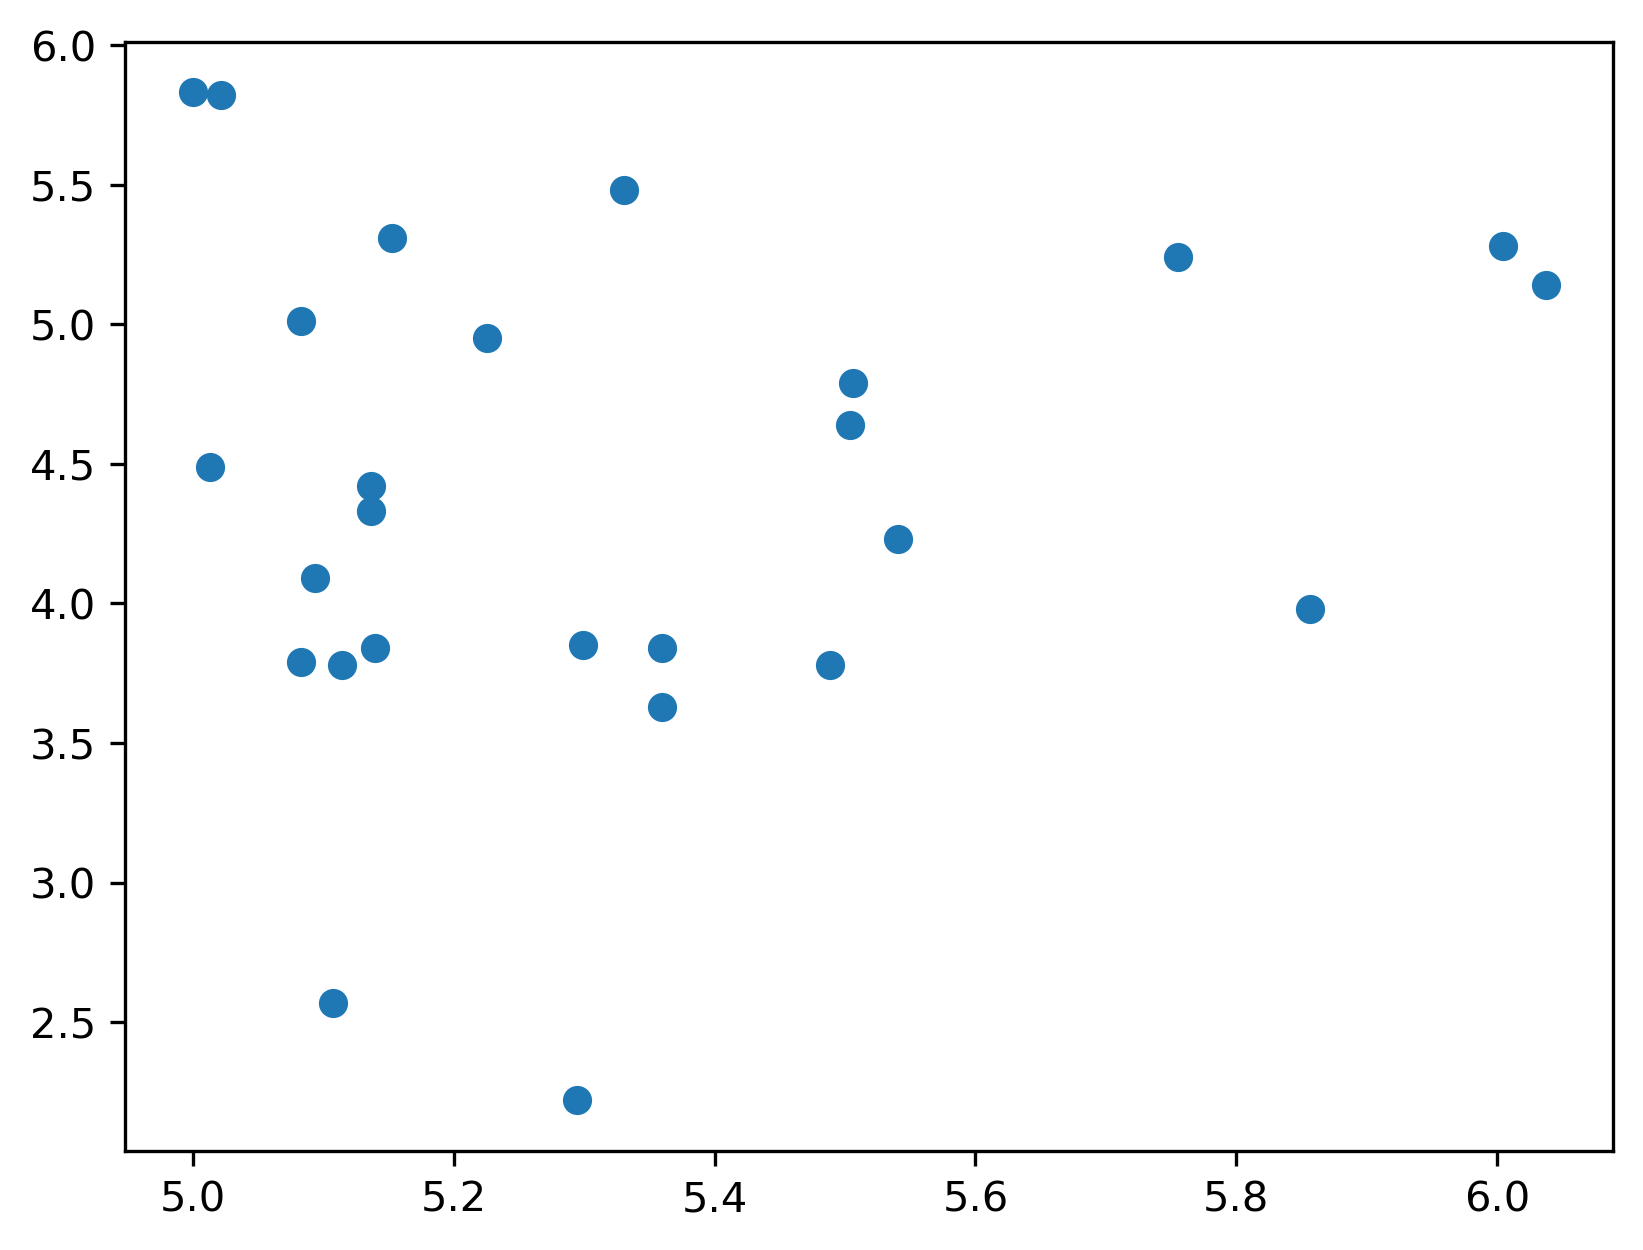

In [14]:
# first, just compare the log of the total mass, log_mtot, to the log of the luminosity density (L_sun pc^-3), log_rho

log_masses = simple_clusters_min35_min14['Log_Mtot']
log_rho = simple_clusters_min35_min14['rho_0']

plt.scatter(log_masses, log_rho)

# this doesn't work, because the clusters all have different sizes! Need to get total luminosity, and compare that

Text(0.5, 1.0, 'Globular Cluster Mass-Luminosity Relationship')

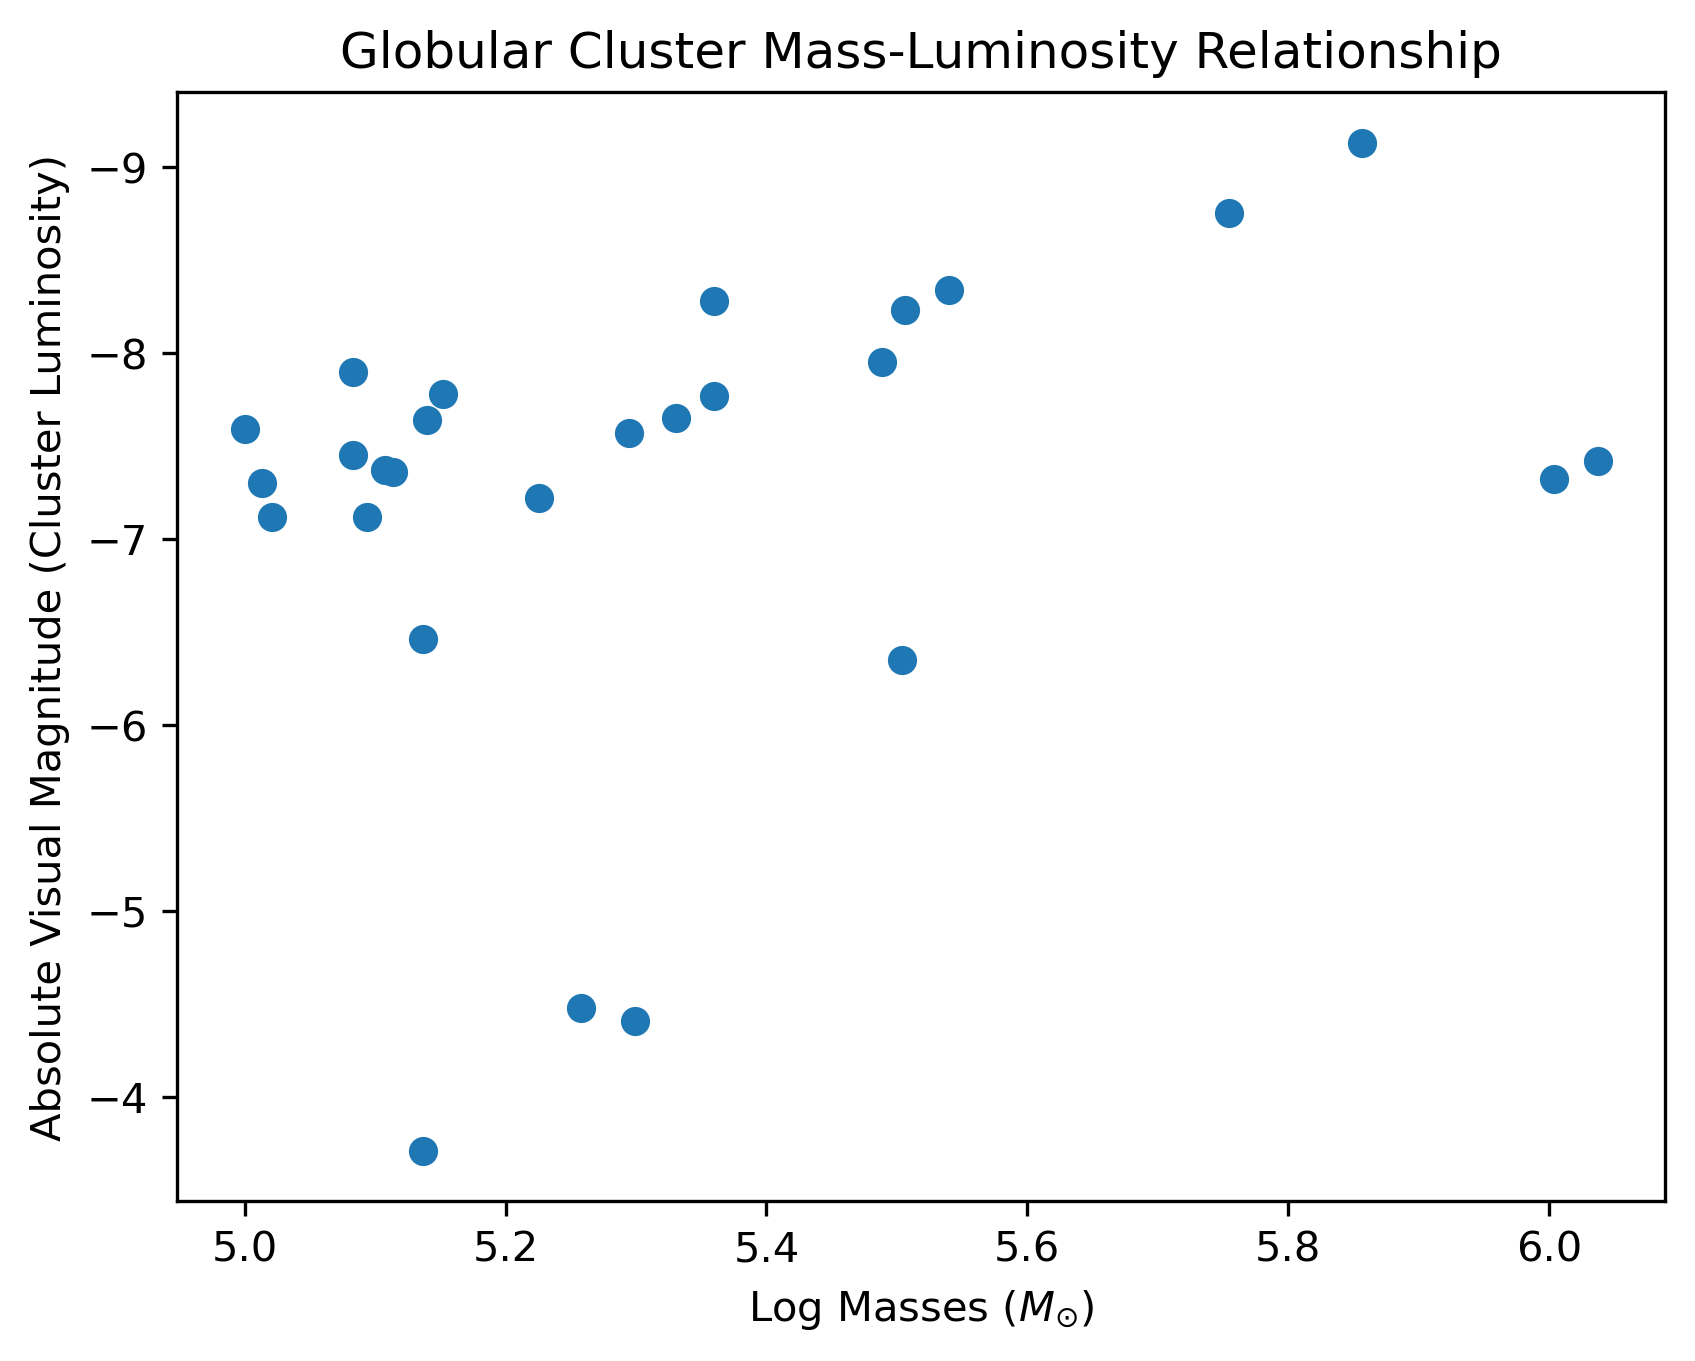

In [15]:
# first, try comparing absolute visual magnitude (cluster luminosity),  M_V,t = V_t - (m-M)V with cluster mass:

log_masses = simple_clusters_min35_min14['Log_Mtot']
masses = 10**log_masses

simple_clusters_min35_min14['M_V,t'] = [float(x) if x not in ['N/A', ''] else np.nan for x in simple_clusters_min35_min14['M_V,t']]
log_lum = simple_clusters_min35_min14['M_V,t']
lum = 10**log_lum

plt.scatter(log_masses, log_lum)
# Flip the y-axis to go from dimmest to brightest top to bottom
plt.gca().invert_yaxis()
plt.xlabel(r'Log Masses ($M_{\odot}$)')
plt.ylabel(r'Absolute Visual Magnitude (Cluster Luminosity)')
plt.title('Globular Cluster Mass-Luminosity Relationship')

## Code from when using McLaughlin masses -- no longer using 

In [206]:
"""
The catalog does not list a cluster mass. However, it is mentioned in the bibliography that McLaughlin & van der Marel 2005 has 
cluster masses, so I will take the masses from that table and put them into the text file called 'masses.txt'
"""

# Read the file and extract the relevant part
with open('/Users/adeutsch/Desktop/UVA/25 Spring/research-pulsar/masses.txt', 'r') as f:
    lines = f.readlines()

# Read the data part into an Astropy Table with fixed-width columns
col_names = ['Cluster', 'popML', 'E_popML', 'e_popML', 'model', 'Mtot', 'E_Mtot',
                   'e_Mtot', 'Eb', 'E_Eb','e_Eb', 'Sigma0', 'E_Sigma0', 'e_Sigma0', 
                   'rho0', 'E_rho0', 'e_rho0', 'Sigmah', 'E_Sigmah', 'e_Sigmah',
                   'sigp0', 'E_sigp0', 'e_sigp0', 'vesc0', 'E_vesc0', 'e_vesc0',
                   'trh', 'E_trh', 'e_trh', 'f0', 'E_f0', 'e_f0']
col_starts = [0,12,18,24,30,33,38,43,48,54,59,64,69,74,79,85,90,95,101,106,112,118,124,129,135,142,148,154,159,164,171,179]
col_ends = [11,17,23,29,32,37,42,47,53,58,63,68,73,78,84,89,94,100,105,111,117,123,128,134,141,147,153,158,163,170,176,182]

masses = ascii.read(lines, format='fixed_width', names=col_names, col_starts=col_starts, col_ends=col_ends)

In [217]:
# now, only keep the rows in masses that are for clusters we are interested in

# Define list of clusters of interest
search_values = [s.replace(" ", "") for s in filtered_GMRT_table['ID']]

# Initialize list to store indices of clusters to keep
keep_clusters = []

# Loop through each row and check if it is a cluster of interest
for idx, row in enumerate(masses):
    for search in search_values:
        if search in row['Cluster']:
            keep_clusters.append(idx)
            break

kept_cluster_masses = masses[keep_clusters]

# also only keep the cluster name, and its log mass:
columns_to_keep = ['Cluster', 'Mtot']
simple_cluster_mass = kept_cluster_masses[columns_to_keep]

# now, average all of the masses for clusters with multiple values:

# group the table by cluster
simple_cluster_mass_grouped = simple_cluster_mass.group_by('Cluster')

# calculate the mean of the log mass for each cluster
avg_mass = []
for group in simple_cluster_mass_grouped.groups:
    cluster = group['Cluster'][0]
    mean_mass = np.mean(group['Mtot'])
    avg_mass.append((cluster,mean_mass))

# Make a new table with avg'd masses
simple_cluster_mass_oneval = Table(rows=avg_mass, names=('Cluster', 'Mtot'))
simple_cluster_mass_oneval['Cluster'] = [c.replace("MW-", "") for c in simple_cluster_mass_oneval['Cluster']]

In [240]:
"""
Now, make a new column, mass, in filtered_GMRT_table, and add a value for 
the log mass everywhere one exists in simple_cluster_mass_oneval
"""

log_masses = np.zeros(81)
filtered_GMRT_table['Log_Mtot'] = log_masses

# Add any masses from the one table to the other:
for i in range(0, len(filtered_GMRT_table)):
    for j in range(0, len(simple_cluster_mass_oneval)):
        if filtered_GMRT_table[i]['ID'] == simple_cluster_mass_oneval[j]['Cluster']:
            filtered_GMRT_table[i]['Log_Mtot'] = simple_cluster_mass_oneval[j]['Mtot']

In [289]:
# remove clusters with known log_masses < 5, sort by declination, and only keep relevant columns (final_table_short)

final_table = filtered_GMRT_table[(filtered_GMRT_table['Log_Mtot'] >= 5.0) | (filtered_GMRT_table['Log_Mtot'] == 0.0)]
final_table.sort('DEC')

KeyError: 'Log_Mtot'

In [252]:
# split into three tables: -40 to -35, -35 to -14, -14 and above:

clusters_min35 = final_table[final_table['DEC']<-35.0]
clusters_min35_min14 = final_table[(final_table['DEC']>-35.0) & (final_table['DEC']<-14.0)]
clusters_min14 = final_table[final_table['DEC']>-14.0]